# Notebook demonstrating the use of Timeseriesai for generating predictions
https://github.com/timeseriesAI/timeseriesAI

## The below is done using the tutorial data set (one state, one season) and is a very small dataset so the results are only intended for use on how to use this, not necessarily what the ML capability is

### uses env timeseriesai

In [156]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [157]:
from tsai.all import *
from joblib import Parallel, delayed

In [158]:
data_root = '/media/scottcha/E1/Data/OAPMLData/'
#data_root = '/media/scottcha/E1/Data/Temp/Tutorial/'
ml_path = data_root + '/5.MLData/'
num_features = 978
interpolation = 1
label = 'Day1DangerAboveTreeline'
file_label = 'day1above'
#file_label = 'day1above'
#label = 'Day1DangerAboveTreeline'

In [159]:
def calculate_feature_mean(feature):
    print('On feature: ' + str(feature))
    return np.nanmean(X[0:5000,feature,:])

In [160]:
def calculate_feature_std(feature):
    print('On feature: ' + str(feature))
    return np.nanstd(X[0:5000,feature,:])

In [161]:
means_fn = ml_path + '/feature_means_interpolation' + str(interpolation) + '_' + file_label + 'x.npy'
std_fn = ml_path + '/feature_std_interpolation' + str(interpolation)  + '_' + file_label +   'x.npy'

In [162]:
#load the X train data from numpy as memmapped file
X = np.load(ml_path + '/Xtrain_batch_0_' + file_label + '_on_disk.npy', mmap_mode='r')

In [163]:
#if we don't have cached versions of these we need to calcualte this for the feature
#standardization, this takes awhile and requires a lot of memory so I only do it on a subset
#of the data (first 100000 rows)
feature_means = Parallel(n_jobs=4)(map(delayed(calculate_feature_mean), range(0,num_features)))

In [164]:
feature_std = Parallel(n_jobs=4)(map(delayed(calculate_feature_std), range(0,num_features)))

In [165]:
#cache the values
np.save(means_fn, np.asarray(feature_means))

In [166]:
np.save(std_fn, np.asarray(feature_std))

In [167]:
#load the values
feature_means = np.load(means_fn)

In [168]:
feature_means[:10]

array([1.05775602e-04, 1.32891160e-04, 8.02069117e-05, 1.09098663e-04,
       1.21436802e-04, 9.67883243e-05, 1.02714672e-04, 1.10764820e-04,
       9.48200541e-05, 1.13074675e-04], dtype=float32)

In [169]:
feature_std = np.load(std_fn)

In [170]:
feature_std[:10]

array([3.7763642e-05, 4.7496345e-05, 4.2003736e-05, 1.6916270e-05,
       1.9034911e-05, 1.8437722e-05, 2.3624532e-05, 2.3937930e-05,
       2.4867604e-05, 2.5147510e-05], dtype=float32)

In [171]:
#load the full X datafile which has both Train and Test concated
X = np.load(ml_path + '/X_all_' + file_label + '.npy', mmap_mode='r')

In [173]:
#read in the corresponding label files and concat them
#can get the right values here based on the contents of hte ml_path directory
num_y_batches = 4
num_y_train_files_per_batch = 10
num_y_test_batches = 1
num_y_test_files_per_batch = 10


y_df = None
for i in range(0, num_y_batches):
    for j in range(0, num_y_train_files_per_batch):        
        df = pd.read_parquet(ml_path + '/y_train_batch_' + str(i) + '_' + file_label + '_' + str(j) + '.0.parquet')  
        y_df = pd.concat([y_df, df])

for i in range(0, num_y_test_batches):
    for j in range(0, num_y_test_files_per_batch):
        df = pd.read_parquet(ml_path + '/y_test_batch_' + str(i) + '_' + file_label + '_' + str(j) + '.0.parquet')  
        y_df = pd.concat([y_df, df])

y_df = y_df.reset_index(drop=True)

In [177]:
y_df.shape

(50000, 301)

In [178]:
no_dupes = y_df.drop_duplicates()

In [179]:
no_dupes.shape

(23440, 301)

In [180]:
y_df['season'].value_counts()

17-18    16488
16-17    12822
15-16    10690
18-19    10000
Name: season, dtype: int64

In [181]:
y_df['parsed_date'].value_counts()

2018-02-13    1040
2017-12-12     845
2018-04-28     760
2017-12-13     760
2018-12-20     705
              ... 
2018-12-19       2
2019-02-21       2
2019-02-23       2
2019-03-21       2
2019-01-20       2
Name: parsed_date, Length: 546, dtype: int64

In [182]:
#certain values can be very overrepresented due to the oversampling methods, check them
y_df[['UnifiedRegion', 'parsed_date', 'season']][y_df['season']=='18-19'].groupby(['UnifiedRegion', 'parsed_date']).count().sort_values('season', ascending=False)

season
UnifiedRegion             parsed_date        
WA Cascades East, North   2018-12-12      457
WA Cascades East, Central 2019-01-03      441
WA Cascades West, South   2018-12-20      411
                          2019-02-12      378
WA Cascades East, North   2018-12-13      376
...                                       ...
Stevens Pass              2019-02-22        2
                          2019-02-28        2
                          2019-03-02        2
                          2019-03-26        2
Mt Hood                   2018-12-19        2

[211 rows x 1 columns]

In [183]:
#cache the labels 
pickle.dump( y_df, open( ml_path + 'y_' + file_label + 'df.p', 'wb' ) )

In [184]:
y_df = pickle.load( open( ml_path + 'y_' + file_label + 'df.p', 'rb' ) )

In [185]:
y_df.shape

(50000, 301)

In [186]:
y_df[label].value_counts()

Low             13926
High            13601
Considerable    11302
Moderate        11171
Name: Day1DangerAboveTreeline, dtype: int64

In [187]:
#convert the labels to encoded values
y_df[label + '_Cat'] = y_df[label].astype('category')
y = y_df[label + '_Cat'].cat.codes.values

In [188]:
y_df[label + '_Cat']

0        Considerable
1        Considerable
2            Moderate
3                High
4                High
             ...     
49995             Low
49996             Low
49997             Low
49998             Low
49999             Low
Name: Day1DangerAboveTreeline_Cat, Length: 50000, dtype: category
Categories (4, object): ['Considerable', 'High', 'Low', 'Moderate']

In [189]:
y_df[label + '_Cat'].cat.codes.head()

0    0
1    0
2    3
3    1
4    1
dtype: int8

In [215]:
dict( enumerate(y_df[label + '_Cat'].cat.categories ) )

{0: 'Considerable', 1: 'High', 2: 'Low', 3: 'Moderate'}

In [190]:
y.shape

(50000,)

In [191]:
#X_size=25000

In [192]:
#index file which indicates which rows in X are train or test
#be carful these don't overlap
train_test_split = 40000
#can use a smaller train subset to make development faster
splits_2 = (L([i for i in range(0,train_test_split)]), L([i for i in range(40000,40000+10000)]))

In [193]:
splits_2

((#40000) [0,1,2,3,4,5,6,7,8,9...],
 (#10000) [40000,40001,40002,40003,40004,40005,40006,40007,40008,40009...])

In [194]:
#load and check the means and std deviations
feature_means = (np.nan_to_num(feature_means))

In [195]:
np.isnan(feature_means).any()

False

In [196]:
feature_std = (np.nan_to_num(feature_std, nan=1.0))

In [197]:
np.isnan(feature_std).any()

False

In [198]:
#method to standardize each batch while also replacing any nans with the mean value before standarization
class TSStandardizeNanMeanReplaceNan(Transform):
    "Standardize/destd batch of `NumpyTensor` or `TSTensor`"
    parameters, order = L('mean', 'std'), 99
    def __init__(self, mean=None, std=None, by_sample=False, by_var=False, verbose=False):
        self.mean = tensor(mean) if mean is not None else None
        self.std = tensor(std) if std is not None else None
        self.by_sample, self.by_var = by_sample, by_var
        if by_sample and by_var: self.axes = (2)
        elif by_sample: self.axes = (1, 2)
        elif by_var: self.axes = (0, 2)
        else: self.axes = ()
        self.verbose = verbose

    @classmethod
    def from_stats(cls, mean, std): return cls(mean, std)

    def setups(self, dl: DataLoader):
        if self.mean is None or self.std is None:
            pv(f'{self.__class__.__name__} setup mean={self.mean}, std={self.std}, by_sample={self.by_sample}, by_var={self.by_var}', self.verbose)
            x, *_ = dl.one_batch()
            x = torch.where(torch.isnan(x), torch.zeros_like(x), x)
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            pv(f'mean: {self.mean}  std: {self.std}\n', self.verbose)

    def encodes(self, x:(NumpyTensor, TSTensor)):
        fill_values = torch.zeros_like(x)
        std_values = torch.zeros_like(x)       
        for i in range(0,x.shape[1]):
            fill_values[:,i,:] = torch.full_like(x[:,i,:], feature_means[i])
            std_values[:,i,:] = torch.full_like(x[:,i,:], feature_std[i])
        
        x = torch.where(torch.isnan(x), fill_values, x)
       
        if self.by_sample:        
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            
        t = (x - fill_values) / std_values
        del fill_values, std_values
        return torch.where(torch.isnan(t), torch.zeros_like(t), t)

In [199]:
X.shape

(50000, 978, 180)

In [200]:
#create the dataset
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits_2, inplace=True)

In [201]:
X[0]

memmap([[          nan,           nan,           nan, ..., 7.4142859e-05,
         7.2285715e-05, 7.9285710e-05],
        [          nan,           nan,           nan, ..., 9.0000001e-05,
         8.2999999e-05, 1.0200000e-04],
        [          nan,           nan,           nan, ..., 5.5000000e-05,
         6.8000001e-05, 5.1999999e-05],
        ...,
        [          nan,           nan,           nan, ..., 1.1960000e-01,
         1.1960000e-01, 1.1960000e-01],
        [          nan,           nan,           nan, ..., 1.1960000e-01,
         1.1960000e-01, 1.1960000e-01],
        [          nan,           nan,           nan, ..., 1.1960000e-01,
         1.1960000e-01, 1.1960000e-01]], dtype=float32)

<AxesSubplot:title={'center':'3'}>

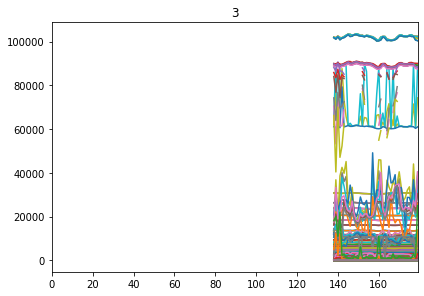

In [146]:
#check on set
show_at(dsets.valid, 6)

In [202]:
#create the dataloader
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64], batch_tfms=[TSStandardizeNanMeanReplaceNan()], num_workers=0)

In [203]:
#check both the train and test sets to ensure that there aren't full rows with all nulls

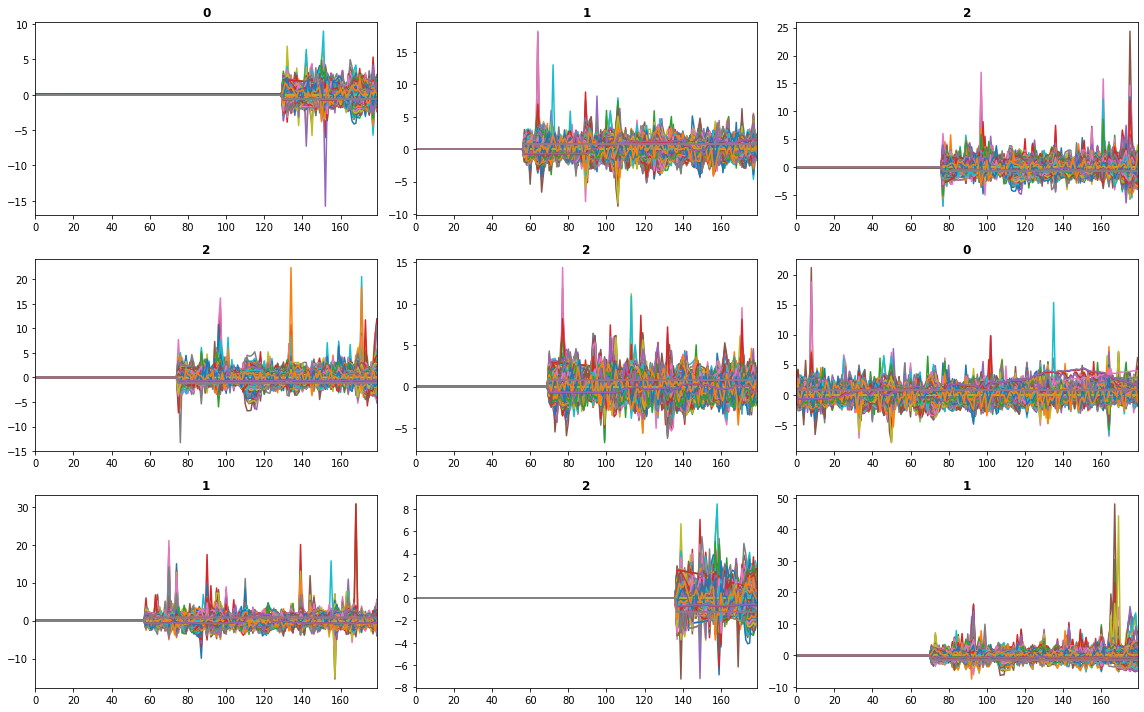

In [204]:
dls.show_batch()

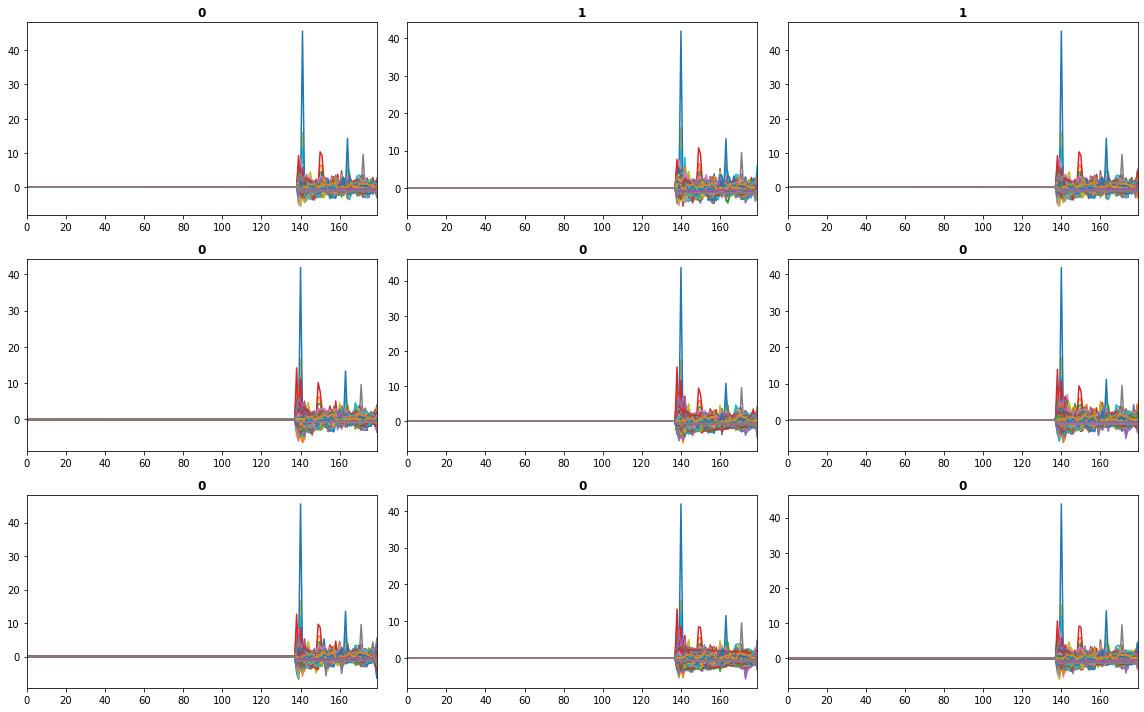

In [205]:
dls.valid.show_batch()

In [206]:
dls.c

4

In [207]:
dls.vars

978

# Lets try and train a model, in the tutorial case we are using an extremely small dataset so no conclusions should be drawn from these results they are for illustrative purposes only

In [208]:
model = InceptionTime(dls.vars, dls.c)
matcor = MatthewsCorrCoef()

#learn = Learner(dls, model, metrics=[matcor, accuracy])
learn = Learner(dls, model, metrics=accuracy)
learn.save('stage0')

Path('models/stage0.pth')

/home/scottcha/miniconda3/envs/timeseriesai/lib/python3.8/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.03981071710586548)

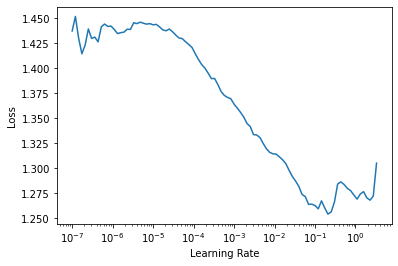

In [209]:
learn.load('stage0')
learn.lr_find()

In [210]:
learn.fit(n_epoch=5, lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.266950,2.520481,0.375900,07:09
1,0.156851,1.698559,0.483000,07:12
2,0.102766,2.423891,0.387300,07:16
3,0.099270,3.610573,0.331600,07:15
4,0.080481,3.230174,0.365800,07:10


In [57]:
#can use this once overfitting is resolved
#learn.fit_one_cycle(3, lr_max=1e-2)
#learn.save('stage1')

### Results
1. looking at the metrics above it seems to be overfitting after epoch 1
2. Looking at the confusion matrix we can see that its ok at distinquishing between 0/1 & 2/3 

Possibilities:
2. There may be features which are causing the overfitting


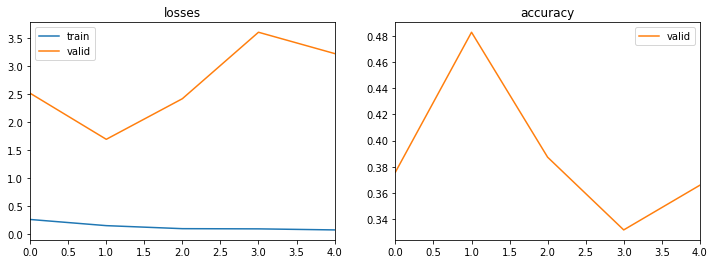

In [211]:
#only works with more than one epoch
learn.recorder.plot_metrics()

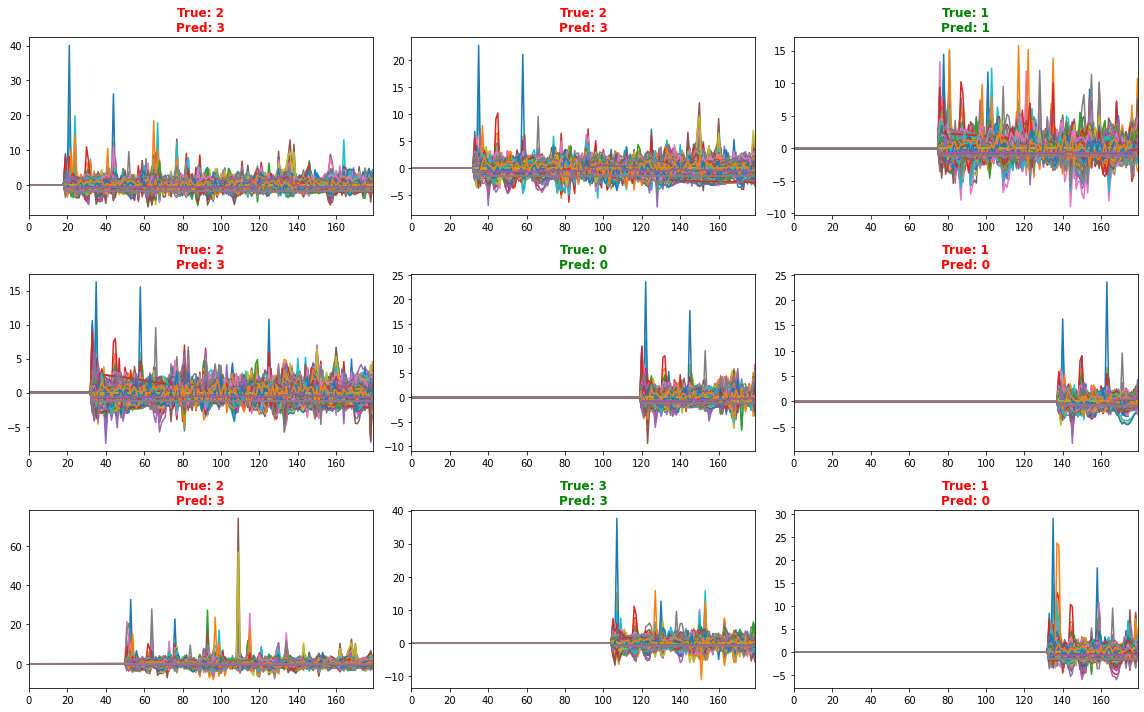

In [212]:
learn.show_results()

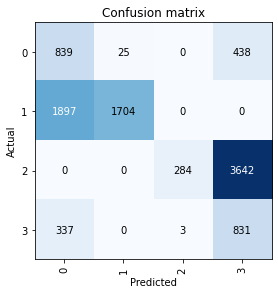

In [213]:
#confustion matrix, not very good, more work to do . . . but the only goal of this notebook was to illustrate the 
#end to end process.  
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()